For this task, you are provided ‘recom.csv’ dataset. In this dataset, you have following columns:

•	Main_ID (Customer ID)
•	Transaction_ID
•	Date
•	Price
•	Code_Product
•	Amount (Order Amount)
•	ItemKey

Well, using this data, you are asked to generate a dataframe in which you recommend an item (or items) for each user.

Hints: 
1)	Please note that there is no rating in the dataset, but, no worries, there is a way to solve this problem.
2)	If possible, please recommend multiple items per user.
3)	You can consider creating pivot table with ‘Main_ID’, ‘ItemKey’, ‘Transaction_ID’.


# Import libraries

In [163]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# EDA

In [164]:
df = pd.read_csv(r'../data/recom.csv')

In [165]:
df.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [166]:
df.shape

(50000, 8)

In [170]:
df.isna().sum()

Unnamed: 0            0
Main_ID               0
Transaction_ID        0
Date                  0
Price                 0
Code_Product          0
Amount                0
ItemKey           21403
dtype: int64

In [171]:
df.duplicated().sum()

0

In [172]:
df['Main_ID'].nunique()

28514

In [173]:
df['Main_ID'].duplicated().sum()

21486

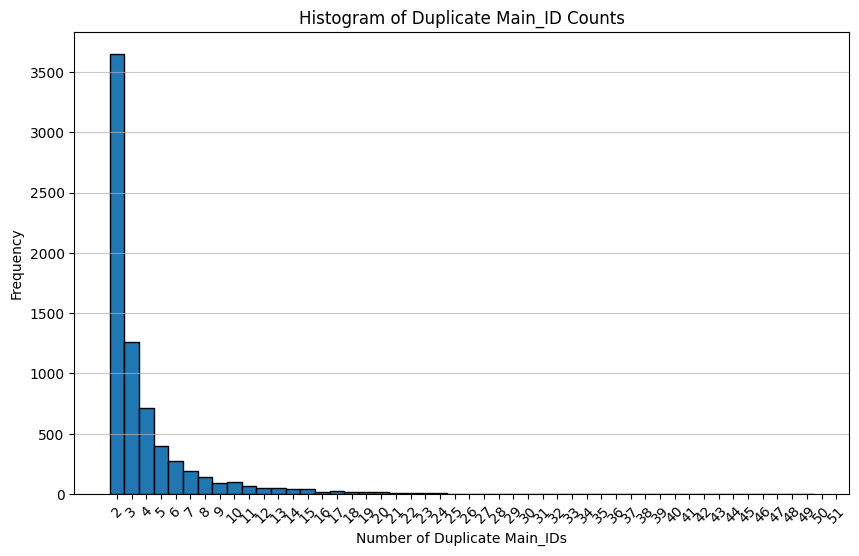

In [174]:
main_id_counts = df['Main_ID'].value_counts()
duplicated_counts = main_id_counts[main_id_counts > 1]

# Create a histogram of the number of rows each duplicated ID has
plt.figure(figsize=(10, 6))
plt.hist(duplicated_counts, bins=range(2, duplicated_counts.max()), edgecolor='black', align='left') # start at 2 counts (all are duplicated)
plt.title('Histogram of Duplicate Main_ID Counts')
plt.xlabel('Number of Duplicate Main_IDs')
plt.ylabel('Frequency')
plt.xticks(range(2, duplicated_counts.max() + 1), rotation = 45)
plt.grid(axis='y', alpha=0.7)
plt.show()

In [175]:
transaction_id_counts = df['Transaction_ID'].value_counts()
transaction_id_counts.value_counts()

count
1    46859
2     1491
3       53
Name: count, dtype: int64

In [176]:
46859 + (2*1491) + (3*53)

50000

## What is the difference between 'Code_Product' and 'ItemKey'

In [182]:
df[['Code_Product', 'ItemKey']].sample(5)

,Code_Product,ItemKey
41775,49427.5,NaN
22680,49291.5,NaN
8901,49291.5,NaN
46777,49291.5,NaN
17887,49292.0,NaN


In [134]:
#Check if Code_product and ItemKey are the same
difference_cp_ik = df['Code_Product'] - df['ItemKey']
difference_cp_ik.value_counts(dropna = False)

0.0    28597
NaN    21403
Name: count, dtype: int64

ItemKey is the same as Code_product but contains NAs, drop this column

In [135]:
df.drop('ItemKey', inplace  = True, axis = 1)

## Distribution and meaning of 'Amount' column

In [79]:
df.dtypes

Unnamed: 0          int64
Main_ID            object
Transaction_ID     object
Date               object
Price             float64
Code_Product      float64
Amount            float64
ItemKey           float64
dtype: object

In [121]:
df['Amount'] = df['Amount'].astype(int)

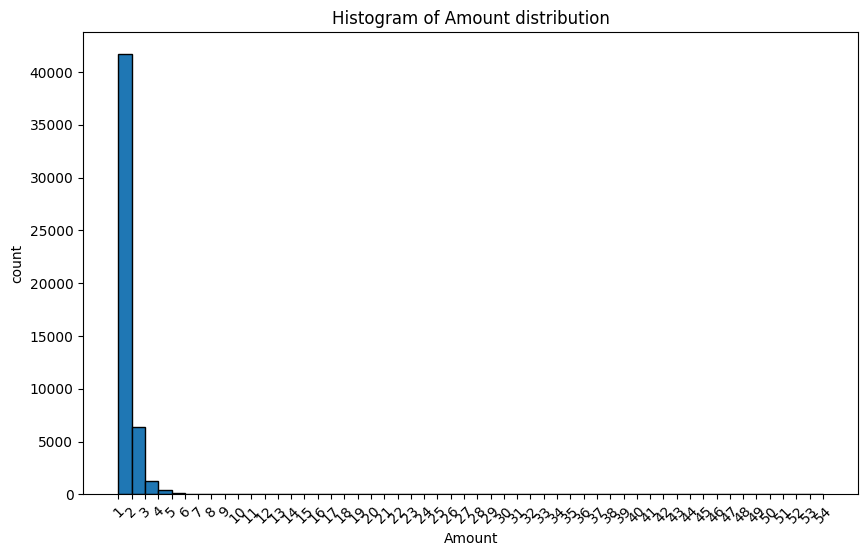

In [125]:
#Visualise distribution of Amount
plt.figure(figsize = (10,6))
plt.hist(df['Amount'], bins = range(1, df['Amount'].max() + 1), edgecolor = 'black')
plt.title('Histogram of Amount distribution')
plt.xlabel('Amount')
plt.ylabel('count')
plt.xticks(range(1, df['Amount'].max() + 1), rotation = 45)
plt.show()

Does 'Amount' refer to number of (different) items bought in that transaction, or number of same item? 

In [225]:
product49291 = df[df['Code_Product'] == 49291.5]
product10013 = df[df['Code_Product'] == 10013.0]
product49291.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN
5,5,0e816717,654c3866,2022-10-21 20:53:45.037,72.0,49291.5,1.0,NaN
18,18,4e30e4bd,e4e0995f,2022-09-13 18:06:33.157,59.0,49291.5,1.0,NaN
44,44,1914e5ad,c263f5ca,2022-11-27 14:34:39.030,19.5,49291.5,1.0,NaN
50,50,21e2aea9,69ef6992,2022-08-28 17:13:01.943,47.5,49291.5,1.0,NaN


The transaction IDS for this example Code_Product when Amount = 5 is unique, so Amount must be if that same product. Price doesn't seem to match up with simple Amount * (single unit price) however, with Amount = 5 for Code_Product 49291.5 $129.5 (on 2022-10-14), and a single unit $72 (on 2022-10-21). You;d expect single unit to be 129.5/5 = $25.9.


Could Price here reflect the single unit price? Have a look at how Price corresponds to amount for a given product

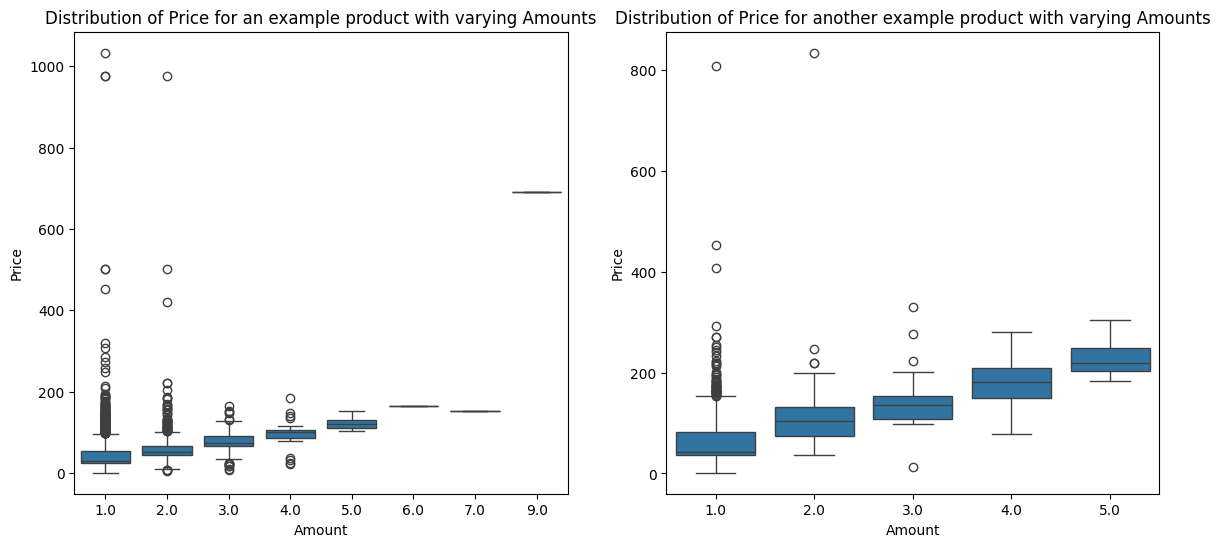

In [226]:
fig, axes = plt.subplots(1,2, figsize = (14,6))

sns.boxplot(x= 'Amount', y = 'Price', data = product49291, ax = axes[0])
axes[0].set_title('Distribution of Price for an example product with varying Amounts')
sns.boxplot(x= 'Amount', y = 'Price', data = product10013, ax = axes[1])
axes[1].set_title('Distribution of Price for another example product with varying Amounts')
plt.show()


Check the medians for each Amount value per product, looks like they're scaling nicely here so Amount indicates the amount of that product bought in that transaction.

In [224]:
product10013.groupby('Amount')['Price'].median()

Amount
1.0     43.50
2.0    104.00
3.0    136.50
4.0    180.50
5.0    219.25
Name: Price, dtype: float64

Lots of variability in single unit cost, but when looking at medians it looks like the prices scale nicely with the amount

## What are the most popular products? Could be 'null' recommendation e.g. for new users

In [157]:
popular_products = df.groupby('Code_Product')['Amount'].sum().sort_values(ascending = False)
popular_products.head()

Code_Product
49292.0    6006
49291.5    5706
5000.5     4730
45004.0    4507
10013.0    1713
Name: Amount, dtype: int32

## Have a look at data grouped by customer

In [147]:
pivot = pd.pivot_table(df, values = 'Amount', index = 'Main_ID', columns = 'Code_Product', aggfunc = 'sum', fill_value = 0) 
pivot

Code_Product,5000.5,5001.0,5001.5,5002.0,5002.5,5003.0,5004.0,5004.5,5005.0,5007.0,...,200035.5,200037.0,200037.5,200038.0,200038.5,200045.5,200046.0,200046.5,200047.0,350027.5
Main_ID,,,,,,,,,,,,,,,,,,,,,
00024de6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00084856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008e848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00096930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000c66b7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff8b1c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff905d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff9726b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## RFM analysis

In [197]:
# convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# find last day in the data as a reference point
current_date = df['Date'].max()

# Calculate Recency (from last date in the dataset), Frequency (number of unique transactions associated with that customer), and Monetary (sum of price) metrics
rfm_df = df.groupby('Main_ID').agg({
    'Date': lambda x: (current_date - x.max()).days, 
    'Transaction_ID': 'nunique',                      # Frequency (unique transactions)
    'Price': 'sum'                                    # Monetary (total amount spent)
})

# Rename columns
rfm_df.rename(columns={'Date': 'Recency', 'Transaction_ID': 'Frequency', 'Price': 'Monetary'}, inplace=True)


In [196]:
rfm_df.sort_values(by = 'Monetary', ascending = False).head()

,Recency,Frequency,Monetary
Main_ID,,,
751131ee,4,39,28082.5
c25c373a,74,19,19561.5
31812c26,80,16,11399.5
4493b2ac,1,33,6318.5
0c87428f,10,17,6065.0


In [198]:
df[df['Main_ID'] == '751131ee']

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
1988,1988,751131ee,9a17721b,2022-10-16 22:01:21.277,421.5,5001.0,2.0,5001.0
3689,3689,751131ee,d72292aa,2022-11-19 18:17:37.767,502.0,5000.5,1.0,5000.5
9338,9338,751131ee,bc79cd20,2022-11-02 17:22:57.013,245.0,45004.0,4.0,45004.0
10134,10134,751131ee,f947b968,2022-11-26 21:47:09.890,453.5,49291.5,1.0,NaN
11309,11309,751131ee,d0b1ebd1,2022-11-26 16:11:55.727,270.0,49292.0,1.0,NaN
12047,12047,751131ee,cd906b74,2022-08-31 19:13:43.897,977.0,49291.5,1.0,NaN
12630,12630,751131ee,88289719,2022-09-02 20:55:10.383,817.5,5009.0,2.0,5009.0
14856,14856,751131ee,96c5d6b3,2022-10-06 20:52:16.973,322.0,10006.0,4.0,NaN
15766,15766,751131ee,9640a472,2022-09-21 19:22:15.650,739.0,5005.0,4.0,5005.0
15996,15996,751131ee,2563b958,2022-09-01 21:09:08.557,857.0,5005.0,4.0,5005.0
